In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

### 10 Words, 5 trials:
list1 = ['calendar', 'telescope', 'volcano', 'museum', 'kite', 'pyramid', 'skeleton', 'fossil', 'galaxy', 'dinosaur']

list2 = ['library', 'aquarium', 'harbor', 'passport', 'suitcase', 'compass', 'maple', 'orchid', 'cactus', 'bamboo']

list3 = ['penguin', 'kangaroo', 'giraffe', 'crocodile', 'hippopotamus', 'rhinoceros', 'elephant', 'lion', 'tiger', 'zebra']

list4 = ['saxophone', 'drum', 'guitar', 'violin', 'piano', 'trumpet', 'flute', 'harmonica', 'cello', 'clarinet']

list5 = ['chef', 'astronaut', 'scientist', 'teacher', 'doctor', 'firefighter', 'detective', 'pilot', 'sailor', 'painter']


In [46]:
""" The columns are:
          1                 2                 3                 4
    correct old word, old but said new, correct new word, new word but said old
"""
data = np.array([23, 3, 22, 2])

In [47]:
mpt_model_code = """
data {
  int<lower=1> N;
  int<lower=1> K;
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> t;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[K] theta;
  theta[1] = t * (d + ((1 - d) * g));
  theta[2] = t * (1 - d) * (1 - g);
  theta[3] = (1 - t) * (1 - g);
  theta[4] = (1 - t) * g;
}

model {
  target += beta_lpdf(t | 1, 1);
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [48]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}


# Compile model
posterior = stan.build(mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


In [49]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.518,0.068,0.394,0.647,0.001,0.001,9176.0,7358.0,1.0
d,0.837,0.076,0.697,0.963,0.001,0.001,7266.0,6011.0,1.0
g,0.119,0.063,0.017,0.235,0.001,0.000,7505.0,5109.0,1.0
theta[0],0.444,0.067,0.322,0.573,0.001,0.000,9122.0,7343.0,1.0
theta[1],0.074,0.035,0.014,0.139,0.000,0.000,7857.0,5893.0,1.0
theta[2],0.425,0.067,0.296,0.548,0.001,0.001,8791.0,6973.0,1.0
theta[3],0.058,0.032,0.007,0.116,0.000,0.000,7566.0,5537.0,1.0
pred_freqs[0],44.446,8.255,27.000,58.000,0.085,0.060,9440.0,8414.0,1.0
pred_freqs[1],7.395,4.414,0.000,15.000,0.045,0.032,9522.0,8872.0,1.0
pred_freqs[2],42.428,8.308,26.000,57.000,0.087,0.062,9085.0,8631.0,1.0


<Axes: xlabel='pred_freqs.4', ylabel='Count'>

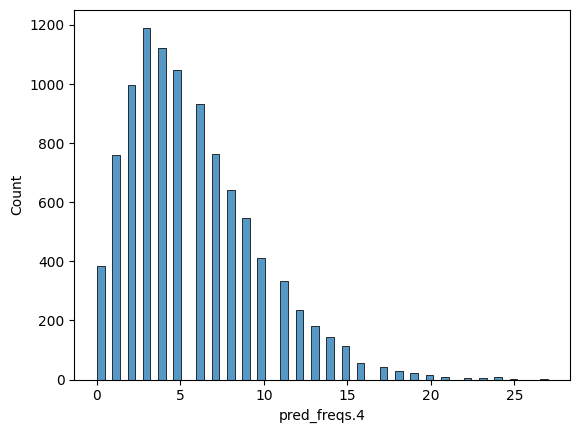

In [50]:
sns.histplot(fit.to_frame().iloc[:, -1])

### Two-high-threshold (2HT) MPT
probabilities according to model

In [51]:
mpt_model_code = """
data {
  int<lower=1> N;
  int<lower=1> K;
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> t;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[K] theta;
  theta[1] = t * d + t * (1 - d) * g; 
  theta[2] = t * (1 - d) * (1 - g);
  theta[3] = (1 - t) * d + (1 - t) * (1 - d) * (1 - g);
  theta[4] = (1 - t) * (1 - d) * g;
}

model {
  target += beta_lpdf(t | 1, 1);
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [52]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}


# Compile model
posterior = stan.build(mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!


In [53]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.520,0.067,0.397,0.648,0.001,0.000,9494.0,7042.0,1.0
d,0.774,0.085,0.617,0.924,0.001,0.001,10109.0,6478.0,1.0
g,0.446,0.169,0.132,0.754,0.002,0.001,10774.0,6880.0,1.0
theta[0],0.455,0.067,0.330,0.583,0.001,0.000,9966.0,7524.0,1.0
theta[1],0.065,0.033,0.012,0.126,0.000,0.000,9904.0,7533.0,1.0
theta[2],0.432,0.066,0.304,0.550,0.001,0.000,9289.0,7625.0,1.0
theta[3],0.049,0.028,0.005,0.099,0.000,0.000,10238.0,6937.0,1.0
pred_freqs[0],45.482,8.289,29.000,60.000,0.085,0.060,9605.0,8295.0,1.0
pred_freqs[1],6.447,4.029,0.000,13.000,0.040,0.029,10154.0,8763.0,1.0
pred_freqs[2],43.219,8.196,27.000,57.000,0.084,0.060,9494.0,7760.0,1.0


<Axes: xlabel='pred_freqs.4', ylabel='Count'>

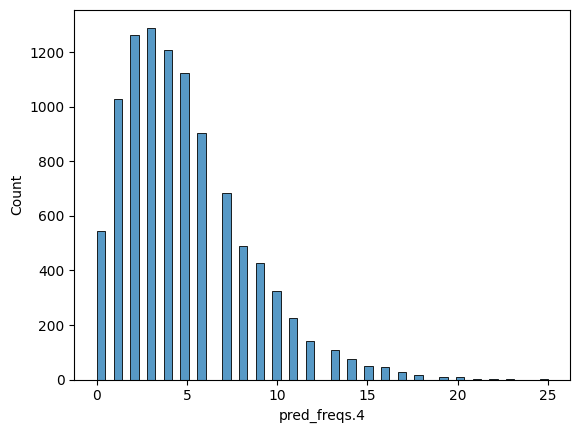

In [54]:
sns.histplot(fit.to_frame().iloc[:, -1])